## Load the Network

In [1]:
%matplotlib notebook

from rlsm.datasets import load_manufacturing

Y, features = load_manufacturing()

## Distance-Dependent Model

In [3]:
from rlsm import ReciprocityLSM

model_dis = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=142)
model_dis.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|██████████████████████████████████████████████████████| 7500/7500 [16:54<00:00,  7.39it/s, 127 steps of size 3.89e-02. acc. prob=0.84]


In [3]:
model_dis.print_summary()

AUC: 0.974, AIC: 2157.546, BIC: 4011.778, DIC: 1940.734

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
   dist_coef      0.54      0.09      0.54      0.38      0.71   3377.21      1.00
       r_var      0.90      0.25      0.87      0.48      1.40    912.13      1.00
  recip_coef      0.23      0.38      0.24     -0.49      0.99   3863.60      1.00
       s_var      3.02      0.70      2.93      1.72      4.41   1021.92      1.00
     sr_corr     -0.05      0.21     -0.05     -0.47      0.34    769.87      1.00
       z_var     19.31      3.23     19.02     13.49     25.74   1553.28      1.00

Number of divergences: 84


## Reciprocity Parameters (Figure 7)

<IPython.core.display.Javascript object>


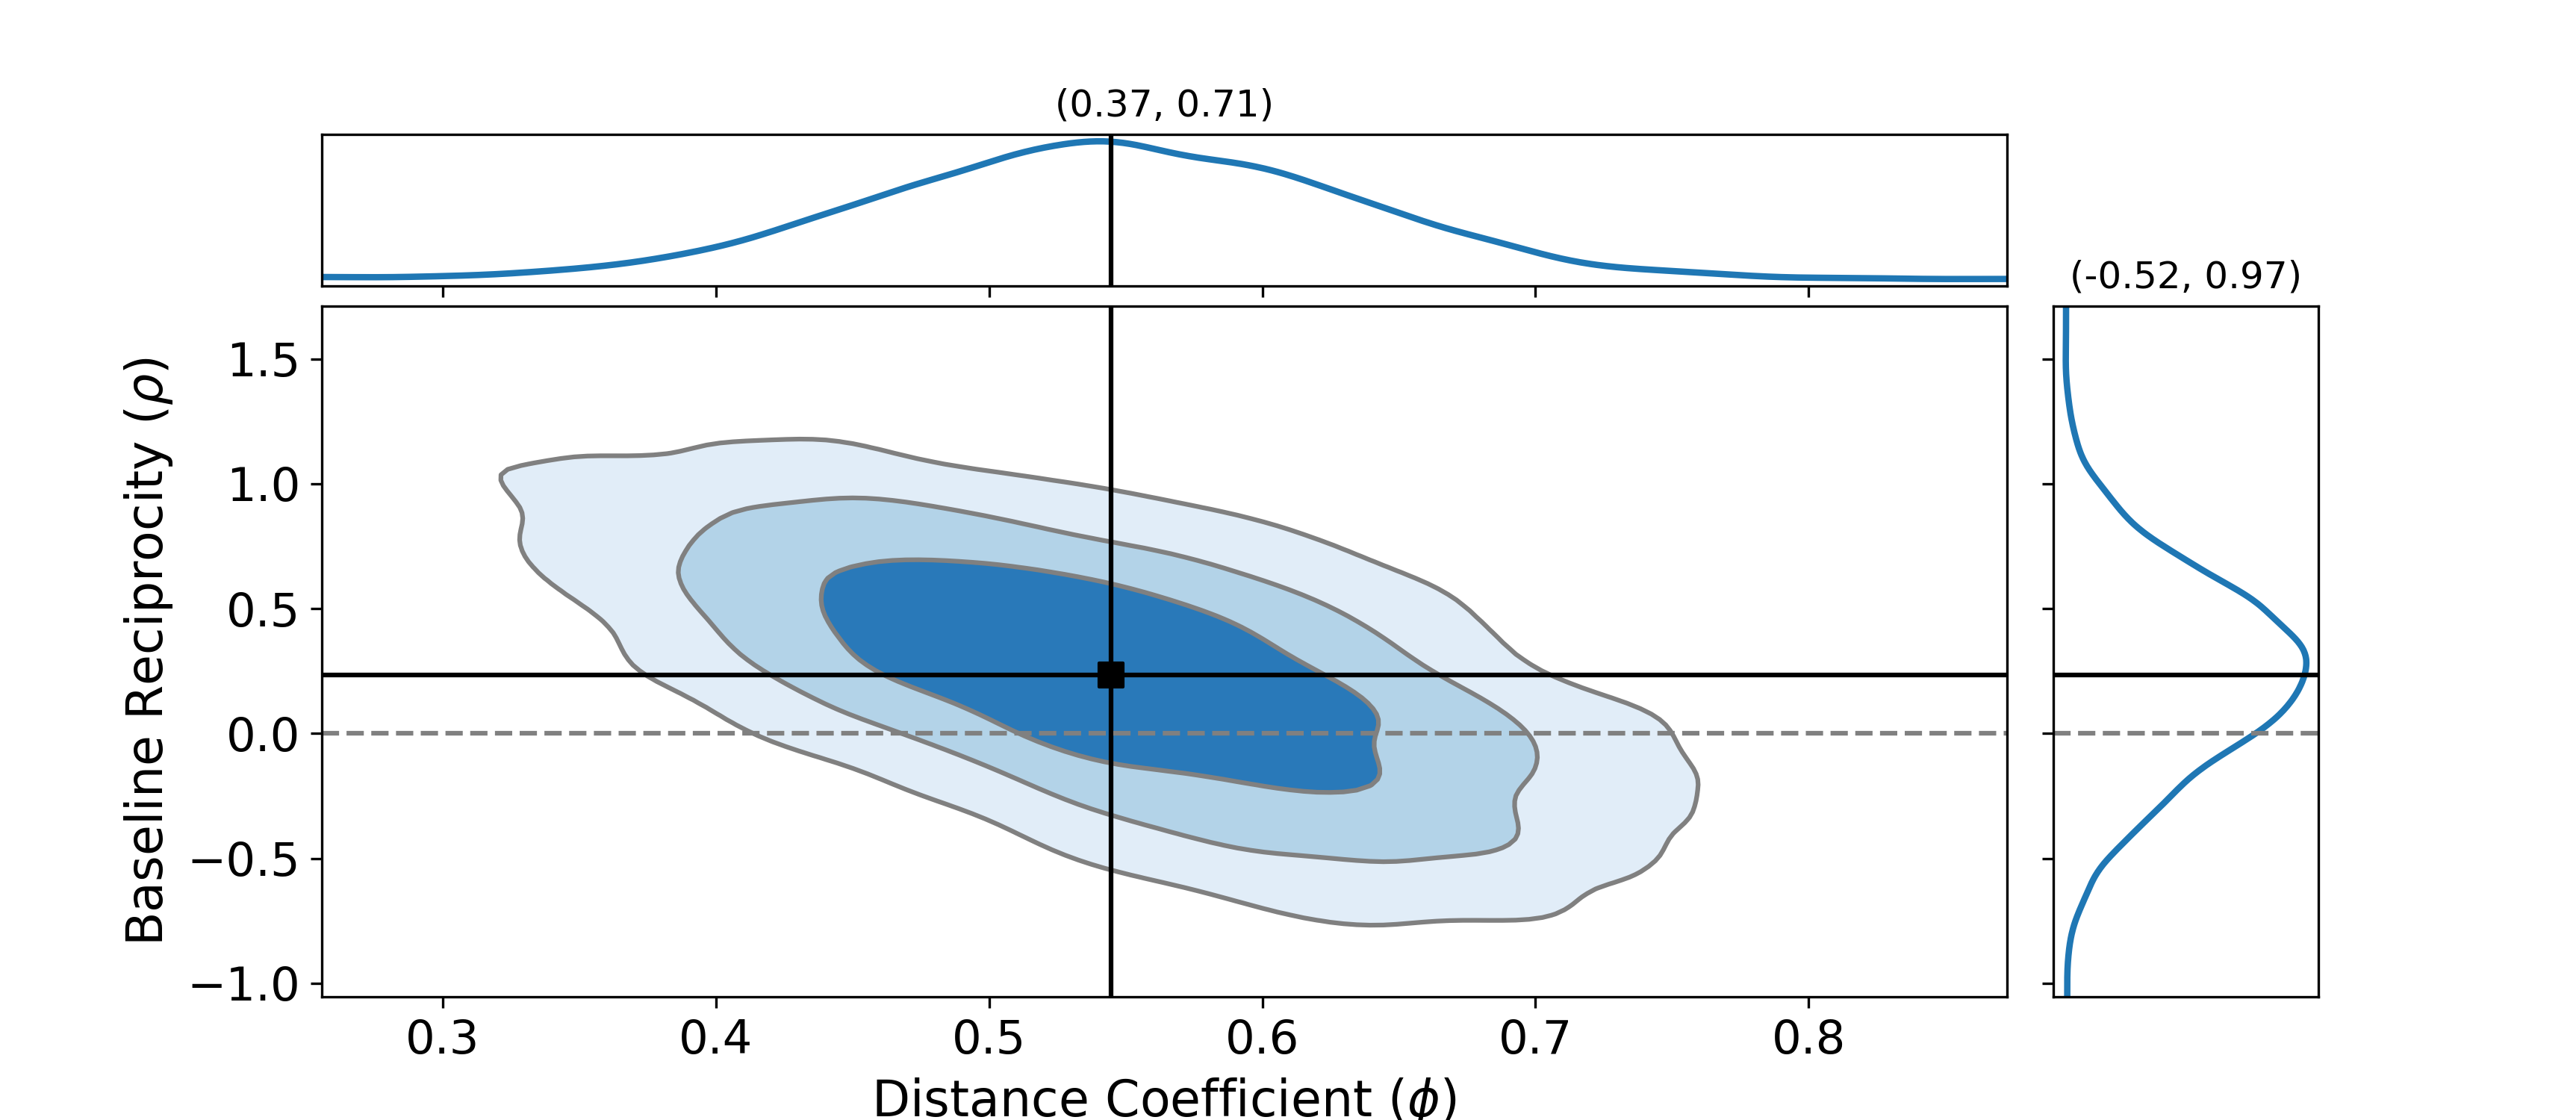

In [4]:
import arviz as az

ax = az.plot_pair(
    {r"$\phi$": model_dis.samples_['dist_coef'][None, ...],
     r"$\rho$": model_dis.samples_['recip_coef'][None, ...]},
    var_names=[r"$\phi$", r"$\rho$"],
    kind="kde",
    kde_kwargs={"hdi_probs": [0.5, 0.8, 0.95], "contourf_kwargs": {"cmap": "Blues"}},
    marginals=True,
    point_estimate="mean",
    figsize=(11.5, 5),
)
ax[1,0].set_xlabel(r"Distance Coefficient ($\phi$)", fontsize=16)
ax[1,0].set_ylabel(r"Baseline Reciprocity ($\rho$)", fontsize=16)
ax[1,0].tick_params(labelsize=15)

phi = model_dis.samples_['dist_coef']
rho = model_dis.samples_['recip_coef']
phi_ci = np.quantile(phi, q=[0.025, 0.975])
rho_ci = np.quantile(rho, q=[0.025, 0.975])
ax[0, 0].set_title(f"({phi_ci[0]:.2f}, {phi_ci[1]:.2f})")
ax[1, 1].set_title(f"({rho_ci[0]:.2f}, {rho_ci[1]:.2f})")
ax[1, 0].axhline(0, linestyle='--', color='gray')
ax[1, 1].axhline(0, linestyle='--', color='gray')

## Log-Odds Ratios and Latent Space (Figure 8)

<IPython.core.display.Javascript object>


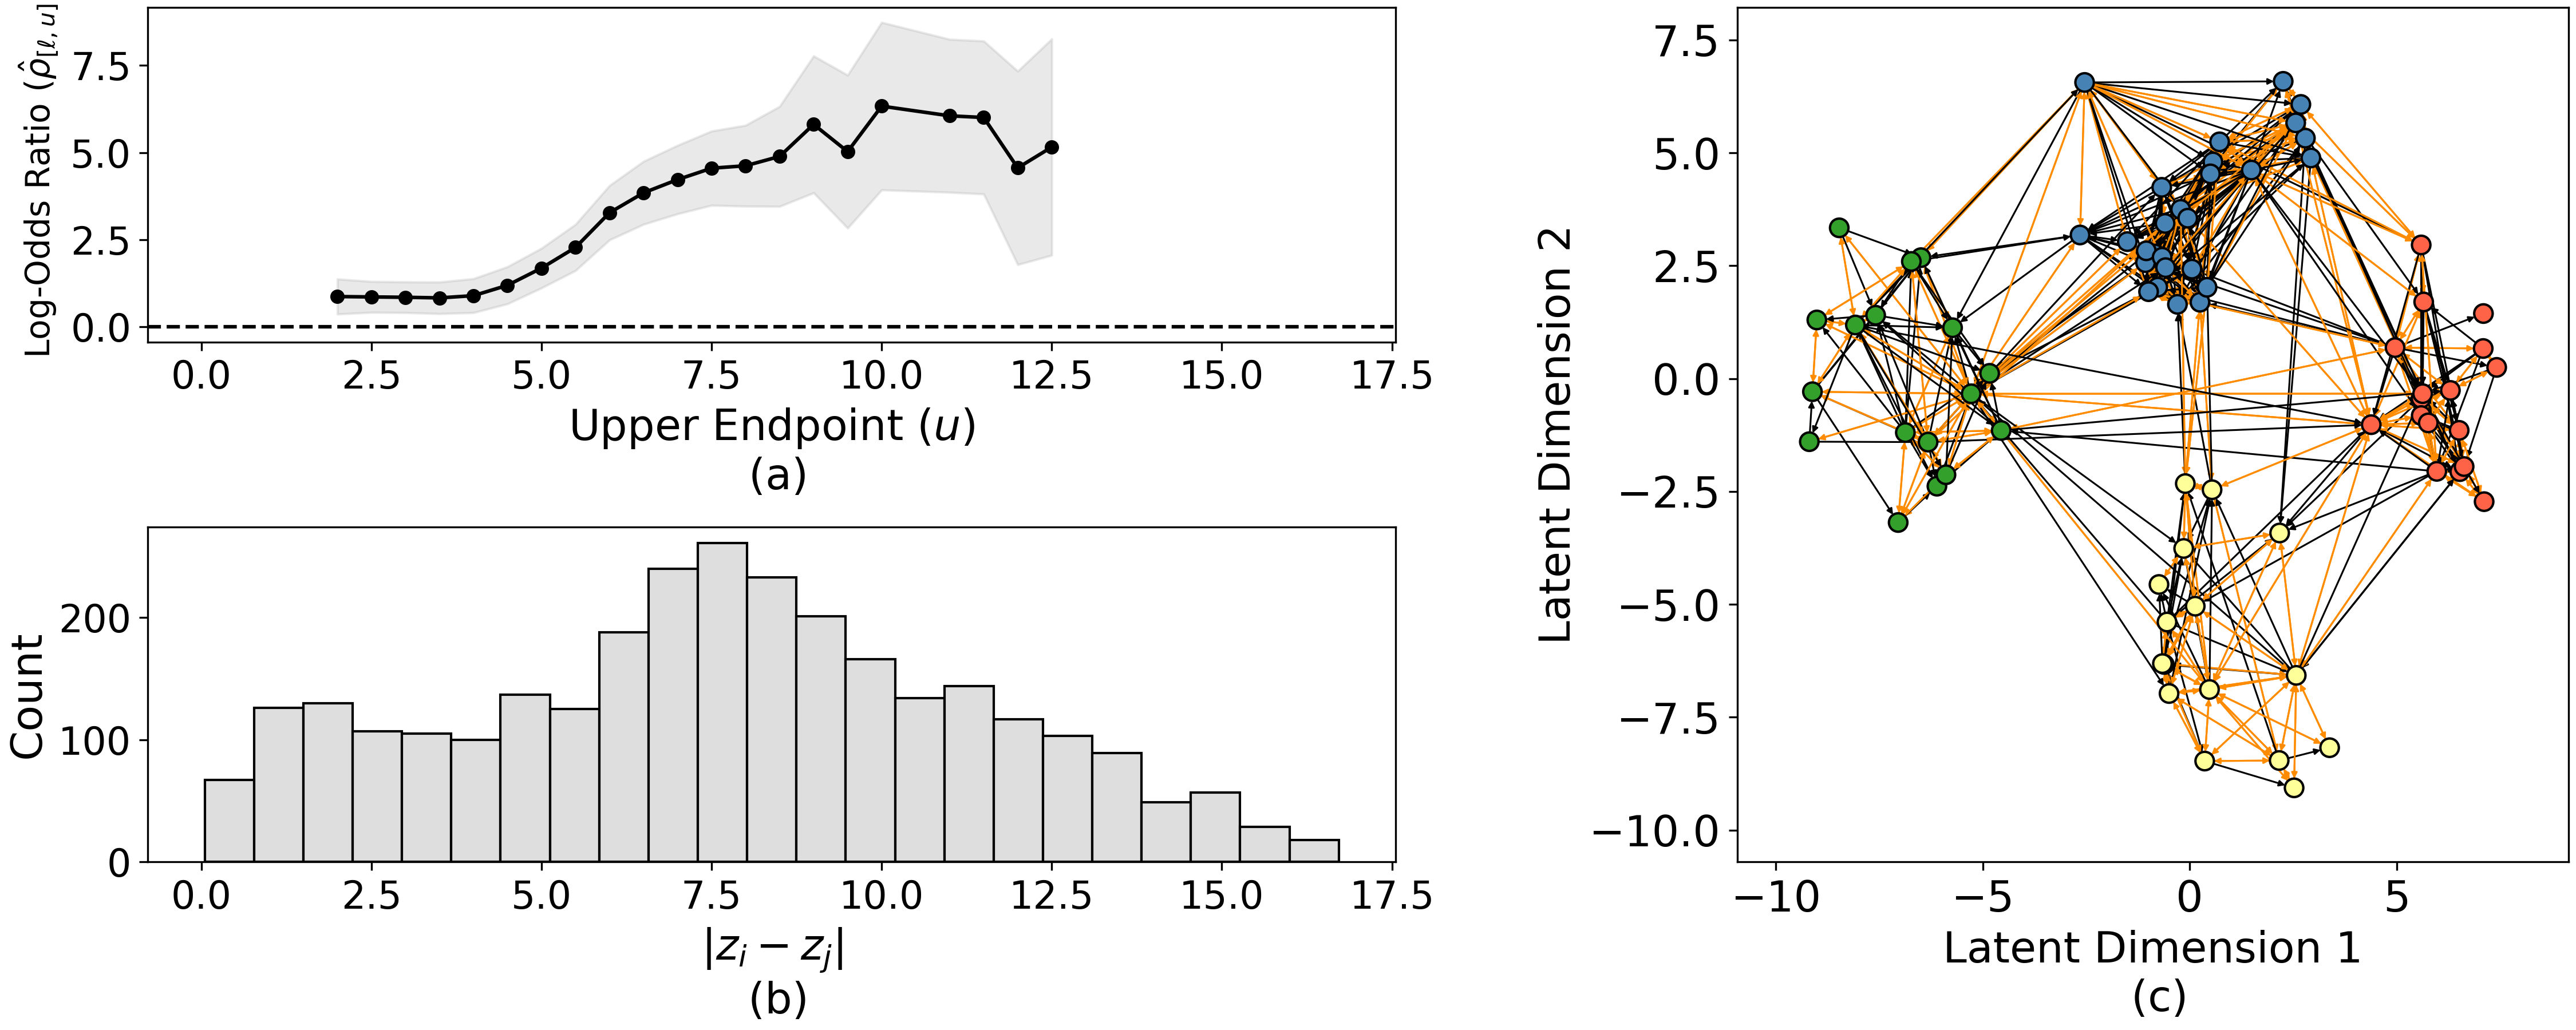

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_52493/285626970.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model_dis.Z_))


In [7]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx

ax = plt.figure(constrained_layout=True, figsize=(15,6)).subplot_mosaic(
    """
    AAABB
    CCCBB
    """,
    gridspec_kw={'wspace': 0.2}
)

D = np.sqrt(pairwise_distance(model_dis.Z_))
d = adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
prods = []
diff = np.diff(qs)[0] 

start = 0
step = 2
end = start + step
while start < d.max():
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= start, d <= end))[0]])
         
    tots = a.sum(axis=0) 
    prods.append(tots[1] * tots[2])
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if np.prod(tots) > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(end)
        
    start += 0.5
    end += 0.5

sns.histplot(d, color='lightgray', edgecolor='k', ax=ax['C'])
ax['A'].plot(np.asarray(dist), res, 'ko-', markersize=5)
ax['A'].set_ylabel(r'Log-Odds Ratio $(\hat{\rho}_{[\ell, u]})$', fontsize=14)
ax['A'].set_xlabel('Upper Endpoint ($u$)\n (a)', fontsize=18)
ax['C'].set_ylabel('Count', fontsize=18)
ax['C'].set_xlabel(r'$|z_i - z_j|$'+ '\n (b)', fontsize=18)
ax['A'].axhline(0., color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

colors = np.asarray(["tomato", "steelblue", "#ffff99", '#33a02c'])
g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model_dis.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=colors[features['locations'].astype(int)-1],
                 edgecolors='k',
                 edge_color=ecolor, width=0.75, with_labels=False,
                 arrowsize=5,
                 node_size=60, ax=ax['B'])
ax['A'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=16)
ax['C'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=16)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=18)
ax['B'].set_ylabel('Latent Dimension 2', fontsize=18)
ax['B'].set_xlabel('Latent Dimension 1\n (c)', fontsize=18)
ax['A'].sharex(ax['C'])

## Conditionally Edge-Independent LSM

In [12]:
model_no = ReciprocityLSM(n_features=2, reciprocity_type='none', random_state=142)
model_no.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|█████████████████████████████████████████████████████████| 7500/7500 [16:16<00:00,  7.68it/s, 127 steps of size 2.85e-02. acc. prob=0.88]


In [13]:
model_no.print_summary()

AUC: 0.976, AIC: 2162.169, BIC: 4217.927, DIC: 1996.743

                mean       std    median      2.5%     97.5%     n_eff     r_hat
     r_var      1.61      0.40      1.58      0.89      2.38    707.50      1.00
     s_var      3.58      0.78      3.50      2.18      5.18    759.25      1.00
   sr_corr      0.81      0.13      0.83      0.56      1.00   1371.16      1.00
     z_var     22.41      3.39     22.12     16.23     29.14   1225.55      1.00

Number of divergences: 101


## Homogeneous Model

In [3]:
model_con = ReciprocityLSM(n_features=2, reciprocity_type='constant', random_state=142)
model_con.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|█████████████████████████████████████████████████████████| 7500/7500 [17:39<00:00,  7.08it/s, 127 steps of size 3.20e-02. acc. prob=0.87]


In [4]:
model_con.print_summary()

AUC: 0.976, AIC: 2175.755, BIC: 4024.005, DIC: 1946.935

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
       r_var      0.98      0.28      0.94      0.50      1.55    436.27      1.00
  recip_coef      1.93      0.25      1.93      1.47      2.43   2470.28      1.00
       s_var      3.26      0.78      3.16      1.81      4.76    381.18      1.01
     sr_corr      0.10      0.20      0.10     -0.29      0.50    197.55      1.02
       z_var     14.49      2.36     14.30     10.18     19.38   1293.94      1.00

Number of divergences: 74
